In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
data = load_diabetes()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10
)

print("train:", X_train.shape, "test:", X_test.shape)


train: (353, 10) test: (89, 10)


In [5]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])


# Explanation

// ...existing code...

This creates a machine that does two steps in order:

- Scale the features (StandardScaler)  
- Fit Ridge regression (Ridge)

Think: “data goes in → gets standardized → model learns coefficients”.

1) Why scaling at all?

Your dataset has multiple features (columns). They can be on different “units/scales”.

Example (toy):

- Feature A: “fat %” ~ 0.1–0.5  
- Feature B: “sodium mg” ~ 200–3000  
- Feature C: “temperature” ~ 5–50

If we fit a model using raw values, the feature with the biggest numerical scale can dominate optimization and regularization behavior.

StandardScaler does:

For each feature j:

$x'_{ij} = \dfrac{x_{ij} - \mu_j}{\sigma_j}$

where $\mu_j$ is the mean of feature $j$ (computed from training data) and $\sigma_j$ is the standard deviation of feature $j$.

After scaling:

- every feature has mean ≈ 0  
- every feature has standard deviation ≈ 1

Intuition: Scaling makes features “comparable”, like converting everything into “how many standard deviations from the average.”

2) Why scaling matters specifically for Ridge

Ridge regression solves:

$\min_{\beta}\; \dfrac{1}{n}\|y - X\beta\|^2 + \alpha\|\beta\|^2$

The penalty $\|\beta\|^2 = \sum_{j=1}^p \beta_j^2$ assumes each coefficient $\beta_j$ is “measured fairly.” If one feature is 1000× larger than another, coefficients for that feature will be scaled down accordingly, which changes how the penalty affects different features. With scaling, Ridge treats each feature on the same footing.

3) Why we need a Pipeline (the leakage reason)

Correct evaluation rule: nothing about the test/validation data should influence training.

Bad practice (data leakage):

```python
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)   # <-- uses ALL data including test
```

This uses test data to compute $\mu$ and $\sigma$ and can make CV/test scores look overly optimistic.

What Pipeline guarantees:

```python
pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])
```

When running cross-validation, scikit-learn will, for each fold:
- Fit scaler on training-fold only → compute $\mu, \sigma$ from training part  
- Transform training-fold using those  
- Transform validation-fold using the same scaler (no refit)  
- Fit ridge on scaled training-fold  
- Evaluate on scaled validation-fold

So: no leakage.

4) What a Pipeline is doing mathematically

You can think of the pipeline as a composed function:

$f(x) = \text{Ridge}(\text{Scale}(x))$

Where Scale(x) = standardized x. Pipeline = “preprocessing + model” treated as one object.

5) What happens when you call .fit and .predict

pipe.fit(X_train, y_train):
- scaler.fit(X_train) → compute $\mu, \sigma$  
- scaler.transform(X_train) → $X'_{\text{train}}$  
- ridge.fit($X'_{\text{train}}$, y_train) → learn $\beta$

pipe.predict(X_test):
- scaler.transform(X_test) using $\mu, \sigma$ from training  
- ridge.predict($X'_{\text{test}}$)

Test data is never used to determine scaling.

6) Why we left Ridge() without alpha here

In Day 5 we will tune $\alpha$ with GridSearchCV. We will search over $\alpha \in \{10^{-3}, \dots, 10^{3}\}$ by passing different values to `ridge__alpha` so they are evaluated fairly.

// ...existing code...

# Gridsearch

In [3]:
param_grid = {
    "ridge__alpha": np.logspace(-3, 3, 13)  # 1e-3 ... 1e+3
}
param_grid


{'ridge__alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
        1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
        1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
        1.00000000e+03])}

In [6]:
gscv = GridSearchCV(
    estimator=pipe, #this means we are tuning the pipeline
    param_grid=param_grid, #specify the hyperparameters to tune
    scoring="neg_root_mean_squared_error",  # maximize "negative RMSE"
    cv=5,
    n_jobs=-1, #use all cpus available
    refit=True, # After GridSearchCV finds the best α using CV, it will refit the best model on the whole training set
    return_train_score=True
)

gscv.fit(X_train, y_train)

print("Best params:", gscv.best_params_)
print("Best CV score (neg RMSE):", gscv.best_score_)
print("Best CV RMSE:", -gscv.best_score_)


Best params: {'ridge__alpha': np.float64(31.622776601683793)}
Best CV score (neg RMSE): -55.2319301222838
Best CV RMSE: 55.2319301222838


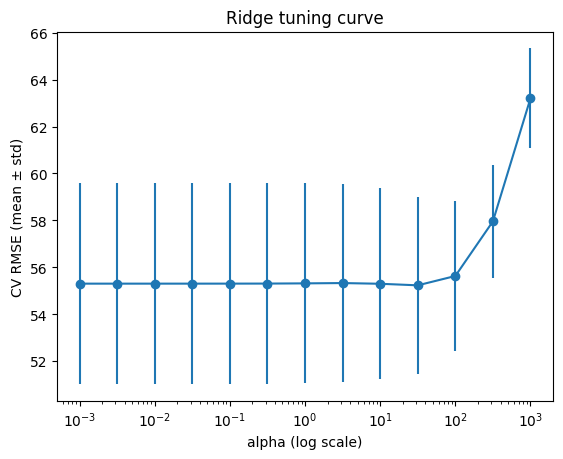

In [7]:
results = gscv.cv_results_
alphas = results["param_ridge__alpha"].data.astype(float)
mean_rmse = -results["mean_test_score"]
std_rmse = results["std_test_score"]

plt.errorbar(alphas, mean_rmse, yerr=std_rmse, fmt="o-")
plt.xscale("log")
plt.xlabel("alpha (log scale)")
plt.ylabel("CV RMSE (mean ± std)")
plt.title("Ridge tuning curve")
plt.show()


In [9]:
best_model = gscv.best_estimator_
y_pred = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

r2_test = r2_score(y_test, y_pred)

print("Test RMSE:", rmse_test)
print("Test R^2 :", r2_test)


Test RMSE: 54.549134225110805
Test R^2 : 0.523993383062876


In [10]:
import joblib

joblib.dump(best_model, "day5_best_ridge_pipeline.joblib")
print("Saved: day5_best_ridge_pipeline.joblib")

loaded = joblib.load("day5_best_ridge_pipeline.joblib")
y_pred2 = loaded.predict(X_test)

print("Max abs diff between predictions:", float(np.max(np.abs(y_pred - y_pred2))))


Saved: day5_best_ridge_pipeline.joblib
Max abs diff between predictions: 0.0
